In [12]:
import glob
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
import time
import matplotlib
import matplotlib.pyplot as plt

from UNETA import attention_unet

In [13]:
device = torch.device('cuda')

In [14]:
class CSIDataset(Dataset):
    def __init__(self, roots):
        self.files = []
        for root in roots:
            self.files.extend(glob.glob(root))
    
    def __len__(self):
        return len(self.files)        
            
    def __getitem__(self, index):
        
        csi_amp_data = loadmat(self.files[index])['amplitude']
        keypoints = np.load(self.files[index].replace("CSI",'GT').replace('.mat','.npy'), allow_pickle=True)[:, 0:2] # shape [17, 2] -> [x, y]
        # print(keypoints)
        csi_amp_data = csi_amp_data.reshape(9, 30, 40)
        return torch.Tensor(csi_amp_data), torch.Tensor(keypoints)

In [15]:
DataPath = [
    r'D:\CSKU\NCU\workspace\data\CSI\S01\A0[1-6]\*.mat',
    r'D:\CSKU\NCU\workspace\data\CSI\S0[2-5]\A0[1-8]\*.mat',
    r'D:\CSKU\NCU\workspace\data\CSI\S09\A0[1-8]\*.mat',
]

In [16]:
dataset = CSIDataset(DataPath)
# print(len(dataset))

# setup split size
split_ratio = 0.6
train_size = int(split_ratio*len(dataset))
val_size = int((len(dataset) - train_size + 1) * 0.5)
test_size = int((len(dataset) - train_size - 1) * 0.5)
# print(train_size, val_size, test_size)
# print(train_size + val_size + test_size)

# split train, val, test dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(0)
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [17]:
# Hyperparameters
lr = 0.001
epochs = 50
model = attention_unet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [6]:
# init weight
w = [1, 1, 1, 1, 1, 1, 1, 2.5, 2.5, 2.5, 2.5, 1, 1, 2.5, 2.5, 2.5, 2.5]

In [19]:
def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

In [23]:
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    print('Epoch {}'.format(epoch+1) + "  LR=" + f"{optimizer.param_groups[0]['lr']}")
    model.train()
    total_train_loss = 0
    with tqdm(train_dataloader, unit='batch', desc='Train') as tqdm_loader:
        for idx, data in enumerate(tqdm_loader):
            csi_amp = data[0].cuda()
            keypoint = data[1].cuda()
            
            outputs = model(csi_amp).cuda()
            
            # Compute loss
            train_loss = 0
            for i in range(17):
                train_loss += weighted_mse_loss(outputs[:,i,:], keypoint[:, i, :], w[i])
            train_loss = torch.div(train_loss, 34)
            
            # Bachward pass and optimization
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            total_train_loss += train_loss.detach().item()
            avg_train_loss = total_train_loss / (idx + 1)
            tqdm_loader.set_postfix(loss=f'{total_train_loss}', avgloss=f'{avg_val_loss:.6f}')
        train_loss_list.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with tqdm(val_dataloader, unit='batch', desc='Validate') as tqdm_loader:
            for idx, data in enumerate(tqdm_loader):
                csi_amp = data[0].cuda()
                keypoint = data[1].cuda()
                
                outputs = model(csi_amp).cuda()
                
                # Compute loss
                val_loss = 0
                for i in range(17):
                    val_loss += weighted_mse_loss(outputs[:,i,:], keypoint[:, i, :], w[i])
                val_loss = torch.div(val_loss, 34)
                 
                total_val_loss += val_loss.detach().item()
                avg_val_loss = total_val_loss / (idx + 1)
                tqdm_loader.set_postfix(loss=f'{total_val_loss}', avgloss=f'{avg_val_loss:.6f}')
        val_loss_list.append(avg_val_loss)
    

Epoch 1  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.92batch/s, avgloss=148768.138021, loss=4016739.7265625]


Epoch 2  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.61batch/s, avgloss=167542.983507, loss=4523660.5546875]


Epoch 3  LR=0.001


Validate: 100%|██████████| 27/27 [00:53<00:00,  1.96s/batch, avgloss=133881.842303, loss=3614809.7421875]


Epoch 4  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.88batch/s, avgloss=135588.802807, loss=3660897.67578125]


Epoch 5  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.86batch/s, avgloss=120207.247251, loss=3245595.67578125]


Epoch 6  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.70batch/s, avgloss=133318.557870, loss=3599601.0625]   


Epoch 7  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.90batch/s, avgloss=160874.309028, loss=4343606.34375] 


Epoch 8  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.89batch/s, avgloss=130254.592014, loss=3516873.984375] 


Epoch 9  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.88batch/s, avgloss=187555.330729, loss=5063993.9296875]


Epoch 10  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.90batch/s, avgloss=115549.679398, loss=3119841.34375]  


Epoch 11  LR=0.001


Validate: 100%|██████████| 27/27 [00:13<00:00,  2.07batch/s, avgloss=82830.668692, loss=2236428.0546875]


Epoch 12  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.87batch/s, avgloss=90829.901331, loss=2452407.3359375]


Epoch 13  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.90batch/s, avgloss=105686.618779, loss=2853538.70703125]


Epoch 14  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.89batch/s, avgloss=76845.339265, loss=2074824.16015625]


Epoch 15  LR=0.001


Validate: 100%|██████████| 27/27 [00:44<00:00,  1.63s/batch, avgloss=76337.151186, loss=2061103.08203125]


Epoch 16  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.85batch/s, avgloss=88769.069734, loss=2396764.8828125]


Epoch 17  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.82batch/s, avgloss=66183.248119, loss=1786947.69921875]


Epoch 18  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.81batch/s, avgloss=103545.095197, loss=2795717.5703125]


Epoch 19  LR=0.001


Validate: 100%|██████████| 27/27 [00:52<00:00,  1.96s/batch, avgloss=70622.416377, loss=1906805.2421875] 


Epoch 20  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.99batch/s, avgloss=65403.822627, loss=1765903.2109375] 


Epoch 21  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.92batch/s, avgloss=55853.261863, loss=1508038.0703125] 


Epoch 22  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.73batch/s, avgloss=59096.603443, loss=1595608.29296875]


Epoch 23  LR=0.001


Validate: 100%|██████████| 27/27 [00:42<00:00,  1.59s/batch, avgloss=62652.574508, loss=1691619.51171875]


Epoch 24  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.97batch/s, avgloss=61352.403935, loss=1656514.90625]   


Epoch 25  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.93batch/s, avgloss=64116.329716, loss=1731140.90234375]


Epoch 26  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.82batch/s, avgloss=56519.868345, loss=1526036.4453125] 


Epoch 27  LR=0.001


Validate: 100%|██████████| 27/27 [00:08<00:00,  3.06batch/s, avgloss=53955.875145, loss=1456808.62890625]


Epoch 28  LR=0.001


Validate: 100%|██████████| 27/27 [00:08<00:00,  3.06batch/s, avgloss=70252.942130, loss=1896829.4375]    


Epoch 29  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.95batch/s, avgloss=65258.237992, loss=1761972.42578125]


Epoch 30  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.91batch/s, avgloss=57306.703848, loss=1547281.00390625]


Epoch 31  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.78batch/s, avgloss=48879.254630, loss=1319739.875]     


Epoch 32  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.93batch/s, avgloss=49924.906829, loss=1347972.484375]  


Epoch 33  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.86batch/s, avgloss=55835.000651, loss=1507545.017578125]


Epoch 34  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.68batch/s, avgloss=46014.073857, loss=1242379.994140625]


Epoch 35  LR=0.001


Validate: 100%|██████████| 27/27 [00:11<00:00,  2.35batch/s, avgloss=53606.645616, loss=1447379.431640625]


Epoch 36  LR=0.001


Validate: 100%|██████████| 27/27 [00:15<00:00,  1.76batch/s, avgloss=51007.773582, loss=1377209.88671875]


Epoch 37  LR=0.001


Validate: 100%|██████████| 27/27 [00:11<00:00,  2.42batch/s, avgloss=49548.343316, loss=1337805.26953125]


Epoch 38  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.57batch/s, avgloss=43053.745877, loss=1162451.138671875]


Epoch 39  LR=0.001


Validate: 100%|██████████| 27/27 [00:12<00:00,  2.08batch/s, avgloss=51339.617694, loss=1386169.677734375]


Epoch 40  LR=0.001


Validate: 100%|██████████| 27/27 [00:46<00:00,  1.72s/batch, avgloss=46201.154514, loss=1247431.171875]  


Epoch 41  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.74batch/s, avgloss=44537.842520, loss=1202521.748046875]


Epoch 42  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.60batch/s, avgloss=45926.459997, loss=1240014.419921875]


Epoch 43  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.87batch/s, avgloss=46668.566334, loss=1260051.291015625]


Epoch 44  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.55batch/s, avgloss=50594.222367, loss=1366044.00390625]


Epoch 45  LR=0.001


Validate: 100%|██████████| 27/27 [00:11<00:00,  2.31batch/s, avgloss=39900.667896, loss=1077318.033203125]


Epoch 46  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.80batch/s, avgloss=42794.857205, loss=1155461.14453125]


Epoch 47  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.87batch/s, avgloss=49200.701244, loss=1328418.93359375]


Epoch 48  LR=0.001


Validate: 100%|██████████| 27/27 [00:09<00:00,  2.71batch/s, avgloss=48901.220052, loss=1320332.94140625]


Epoch 49  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.58batch/s, avgloss=40778.842014, loss=1101028.734375]  


Epoch 50  LR=0.001


Validate: 100%|██████████| 27/27 [00:10<00:00,  2.69batch/s, avgloss=41146.939164, loss=1110967.357421875]


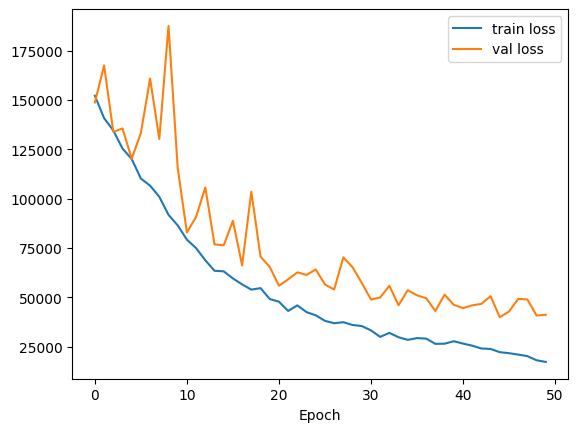

In [24]:
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [27]:
torch.save(model.state_dict(), '../TCN_AA/tcn_aa01.pt')

Inference

In [7]:
import cv2
face = [0,1,2,3,4]
body = [5,6,11,12]
LHand = [6,8,10]
RHand = [5,7,9]
LLeg = [12,14,16]
RLeg = [11,13,15]

limb = np.array([[0,1],[0,2],[1,2],[1,3],[2,4],[3,5],[4,6],[5,6],[5,7],[7,9],[6,8],[8,10],[5,11],[6,12],[11,13],[11,12],[12,14],[14,16],[13,15]])

def showimg(img_path, gt, pred, show):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    if show:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[0].set_title('Groound Truth')
        axes[0].imshow(img)
        
        # Draw limb connections for GT
        for i in range(len(limb)):
            axes[0].plot(gt[0, [limb[i, 0], limb[i, 1]]], gt[1,[limb[i, 0], limb[i, 1]]])
        
        axes[1].set_title('Predict')
        axes[1].imshow(img)
       
        # Draw limb connections for prediction
        for i in range(len(limb)):
            axes[1].plot(pred[0, [limb[i, 0], limb[i, 1]]], pred[1,[limb[i, 0], limb[i, 1]]])
            
        axes[1].scatter(pred[0], pred[1],c = 'red')
        plt.tight_layout()
        plt.show()

In [97]:
%matplotlib inline

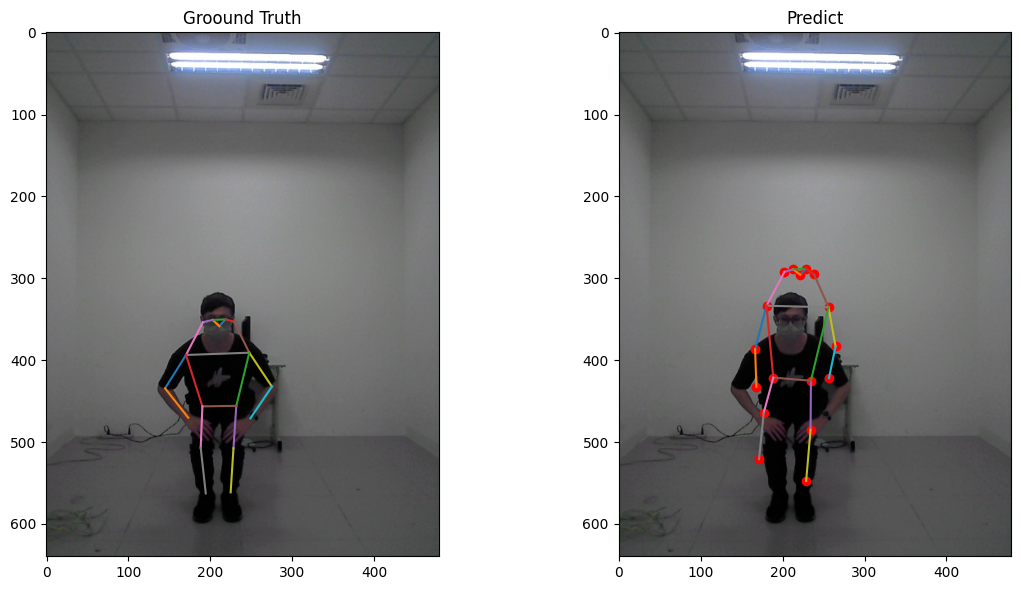

In [98]:
num = 20
img_path = f'D:\\CSKU\\NCU\\workspace\\data\\Video\\Video\\S03\\A01\\frame{num}.jpg'
gt = np.load(f'D:\\CSKU\\NCU\\workspace\\data\\GT\\S03\\A01\\frame{num}.npy').T[:2,:]

CSIamp_data = torch.Tensor(loadmat(f'D:\\CSKU\\NCU\\workspace\\data\\CSI\\S03\\A01\\frame{num}.mat')['amplitude'].reshape(9,30,40))

device = torch.device('cuda')

weight = torch.load('tcn_aa01.pt', weights_only=True)
model = attention_unet().to(device)
model.load_state_dict(weight, strict=False)
model.eval()
pred = model(CSIamp_data.unsqueeze(0).to(device)).squeeze(0).permute(1,0).cpu().detach().numpy()[:2,:]
showimg(img_path,gt,pred,True)

In [4]:
CSIamp_data = torch.empty((9,30,0))

path = '../data/CSI/S03/A07'
for file in os.listdir(path):
    if file.endswith('.mat'):
        a = torch.Tensor(loadmat(os.path.join(path, file))['amplitude'].reshape(9, 30, 40))
        CSIamp_data = torch.cat((CSIamp_data, a), dim=2)
CSIamp_data.shape

torch.Size([9, 30, 14760])

Inference

In [10]:
import cv2
import torch
import numpy as np


cap = cv2.VideoCapture(0)
device = torch.device('cuda')

weight = torch.load('tcn_aa01.pt', weights_only=True)
model = attention_unet().to(device)
model.load_state_dict(weight, strict=False)
model.eval()

# Define the video writer
# Adjust 'output.mp4', the codec, fps, and frame size as needed.
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 25, (480, 640))

time = 0
frame = 0
real_time_data = []
while time != CSIamp_data.shape[-1]:
    # Append the next CSIamp_data slice
    # Ensure CSIamp_data and indexing are correct
    real_time_data.append(CSIamp_data[:, :, time])
    time += 1

    # Process data every 40 frames
    if len(real_time_data) % 40 != 0:
        continue
    
    data = torch.stack(real_time_data[-40:], dim=-1).to(device)
    frame += 1
    print(f"frame:{frame}",data.shape)

    with torch.no_grad():
        pred = model(data.unsqueeze(0)).squeeze(0).permute(1, 0).cpu().detach().numpy()[:2, :]

    # Create a blank image on which to draw
    # Note: OpenCV uses BGR order. This is a black background.
    out_frame = np.zeros((640, 480, 3), dtype=np.uint8)

    # Draw limbs
    # limb should be an array where each entry is [start_joint, end_joint]
    for i in range(len(limb)):
        start_x = int(pred[0, limb[i, 0]])
        start_y = int(pred[1, limb[i, 0]])
        end_x = int(pred[0, limb[i, 1]])
        end_y = int(pred[1, limb[i, 1]])
        cv2.line(out_frame, (start_x, start_y), (end_x, end_y), (255, 255, 255), 2)

    # Draw joints
    for j in range(pred.shape[1]):
        x = int(pred[0, j])
        y = int(pred[1, j])
        cv2.circle(out_frame, (x, y), 5, (0, 0, 255), -1)

    # Write the frame to the video
    out.write(out_frame)

    # If you want to preview the frames, you can show them in a window
    cv2.imshow('Frame', out_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


frame:1 torch.Size([9, 30, 40])
frame:2 torch.Size([9, 30, 40])
frame:3 torch.Size([9, 30, 40])
frame:4 torch.Size([9, 30, 40])
frame:5 torch.Size([9, 30, 40])
frame:6 torch.Size([9, 30, 40])
frame:7 torch.Size([9, 30, 40])
frame:8 torch.Size([9, 30, 40])
frame:9 torch.Size([9, 30, 40])
frame:10 torch.Size([9, 30, 40])
frame:11 torch.Size([9, 30, 40])
frame:12 torch.Size([9, 30, 40])
frame:13 torch.Size([9, 30, 40])
frame:14 torch.Size([9, 30, 40])
frame:15 torch.Size([9, 30, 40])
frame:16 torch.Size([9, 30, 40])
frame:17 torch.Size([9, 30, 40])
frame:18 torch.Size([9, 30, 40])
frame:19 torch.Size([9, 30, 40])
frame:20 torch.Size([9, 30, 40])
frame:21 torch.Size([9, 30, 40])
frame:22 torch.Size([9, 30, 40])
frame:23 torch.Size([9, 30, 40])
frame:24 torch.Size([9, 30, 40])
frame:25 torch.Size([9, 30, 40])
frame:26 torch.Size([9, 30, 40])
frame:27 torch.Size([9, 30, 40])
frame:28 torch.Size([9, 30, 40])
frame:29 torch.Size([9, 30, 40])
frame:30 torch.Size([9, 30, 40])
frame:31 torch.Size